## PE Sentiment

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words("indonesian") + list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data PE

In [3]:
df = pd.read_csv("new_data/amalsholeh _PE _sentiment.csv")
df.head()

content    PE  value sentiment
0  Mohon maaf saya ubah ratingnya untuk perbaikan...  True      2   negatif
1  Suka banget sama aplikasinya, topupnya mudah, ...  True      1   positif
2  Tolong arahannya gimana caranya Saya pengen op...  True      2   negatif
3  Aplikasinya bagus, suka dengan berbagai fiturn...  True      1   positif
4  Kenapa ya kalo isi saldo itu udh d tf tapi mas...  True      1   positif

In [4]:
df.sentiment.value_counts()

positif    324
negatif     18
Name: sentiment, dtype: int64

In [5]:
df.sentiment.value_counts(normalize=True)

positif    0.947368
negatif    0.052632
Name: sentiment, dtype: float64

### Encoding with W2V Model

In [6]:
from gensim.models import Word2Vec

In [7]:
w2v = Word2Vec.load("model/w2v/amalsholeh_review.w2v").wv

In [8]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    
    
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, w2v, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [9]:
vecs.shape

(342, 200)

### Dataset Splitting

In [10]:
X = vecs
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((273, 200), (69, 200), (273,), (69,))

### SMOTE Data Modeling

In [14]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns

In [12]:
print(Counter(y))

Counter({'positif': 324, 'negatif': 18})


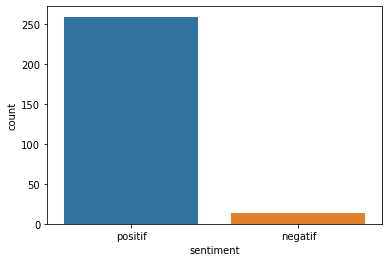

In [15]:
sns.countplot(x=y_train)

Text(0, 0.5, 'X column negatif')

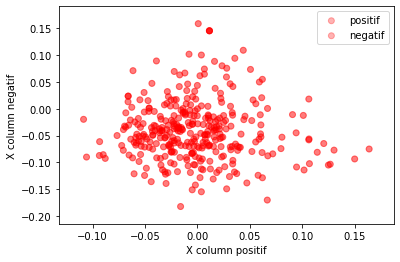

In [16]:
import matplotlib.pyplot as plt

for i, color in enumerate(['positif', 'negatif']):
    plt.scatter(X[:, 0], X[:, 1], c=['b' if p == i else 'r' for p in y], alpha=0.3, label=color)
plt.legend()
plt.xlabel('X column positif')
plt.ylabel('X column negatif')

In [18]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
X_res_test, y_res_test = ros.fit_resample(X_test, y_test)
print('Resampled dataset shape %s' % Counter(y_res))
print('Resample dataset test shape is ', Counter(y_res_test))

Resampled dataset shape Counter({'positif': 259, 'negatif': 259})
Resample dataset test shape is  Counter({'positif': 65, 'negatif': 65})


### Training SVM

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [21]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_res, y_res)

print(model.best_params_)
print(model.score(X_res, y_res), model.best_score_, model.score(X_res_test, y_res_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 0.1, 'algo__gamma': 10.0}
1.0 1.0 0.5


### Evaluation

In [22]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

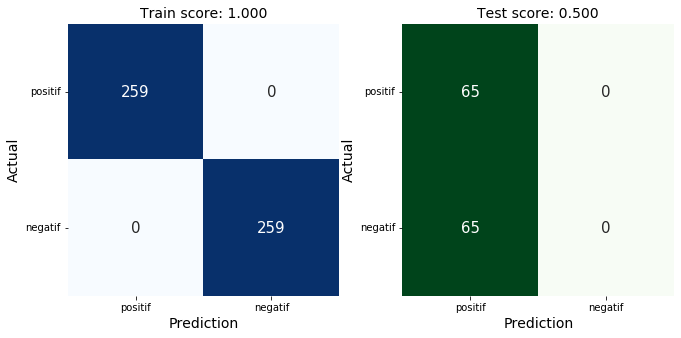

In [23]:
plot_confusion_matrix(X_res, y_res, X_res_test, y_res_test, model)

In [24]:
plot_classification_report(X_res, y_res, X_res_test, y_res_test, model, report=True)

Train report
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       259
     positif       1.00      1.00      1.00       259

    accuracy                           1.00       518
   macro avg       1.00      1.00      1.00       518
weighted avg       1.00      1.00      1.00       518


Test report
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        65
     positif       0.50      1.00      0.67        65

    accuracy                           0.50       130
   macro avg       0.25      0.50      0.33       130
weighted avg       0.25      0.50      0.33       130



C:\Users\Iwan\miniconda3\envs\jcopml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Iwan\miniconda3\envs\jcopml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Iwan\miniconda3\envs\jcopml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Encoding with FastText

In [25]:
from gensim.models import FastText

In [26]:
fastText = FastText.load("model/fasttext/amalsholeh_review.fasttext").wv

In [27]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, fastText, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [28]:
vecs.shape

(342, 200)

### Dataset Splitting

In [29]:
X = vecs
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((273, 200), (69, 200), (273,), (69,))

### SMOTE Data Modeling

In [30]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
X_res_test, y_res_test = ros.fit_resample(X_test, y_test)
print('Resampled dataset shape %s' % Counter(y_res))
print('Resample dataset test shape is ', Counter(y_res_test))

Resampled dataset shape Counter({'positif': 259, 'negatif': 259})
Resample dataset test shape is  Counter({'positif': 65, 'negatif': 65})


### Training with SVM

In [31]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_res, y_res)

print(model.best_params_)
print(model.score(X_res, y_res), model.best_score_, model.score(X_res_test, y_res_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 0.1, 'algo__gamma': 10.0}
1.0 1.0 0.6461538461538462


### Evaluation

In [32]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

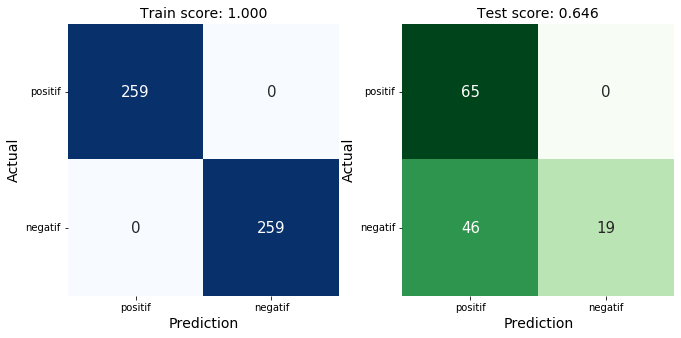

In [33]:
plot_confusion_matrix(X_res, y_res, X_res_test, y_res_test, model)

In [34]:
plot_classification_report(X_res, y_res, X_res_test, y_res_test, model, report=True)

Train report
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       259
     positif       1.00      1.00      1.00       259

    accuracy                           1.00       518
   macro avg       1.00      1.00      1.00       518
weighted avg       1.00      1.00      1.00       518


Test report
              precision    recall  f1-score   support

     negatif       1.00      0.29      0.45        65
     positif       0.59      1.00      0.74        65

    accuracy                           0.65       130
   macro avg       0.79      0.65      0.60       130
weighted avg       0.79      0.65      0.60       130

